# Learning latent force

In [31]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

In [32]:
p53_data = JAXP53_Data(replicate=2)
training_times, gene_expressions = dataset_3d(p53_data)
plot_times, plot_gene_expressions = flatten_dataset_jax(p53_data)

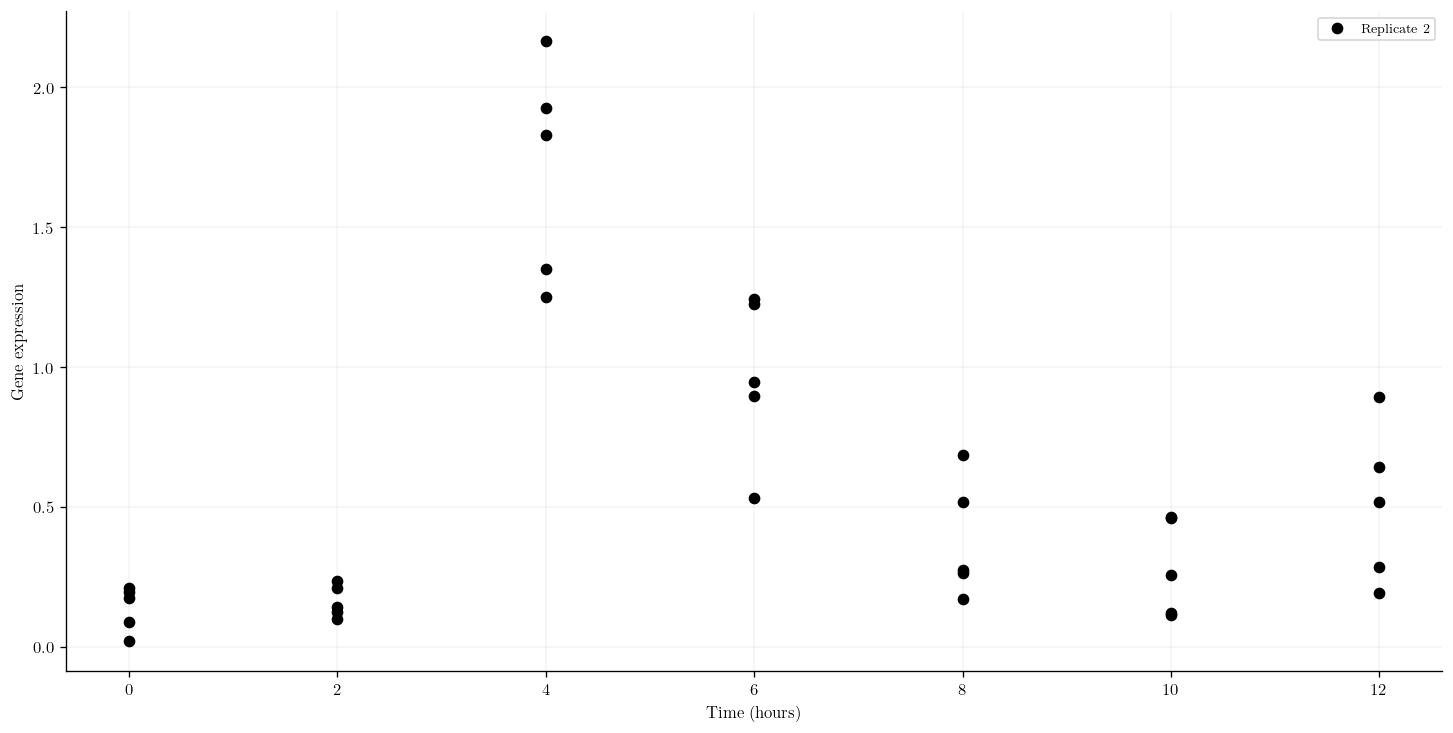

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(plot_times, plot_gene_expressions, "o", label="Replicate 2", color="black")
plt.xlabel("Time (hours)")
plt.ylabel("Gene expression")
plt.legend()
plt.show()

In [34]:
# Generate test points (t, i, 1):
def gen_test_times(t=100):
    """
    Generate testing times for the model of shape (N, 3) where N is the number of testing times. Default is N = 100
    """
    times = jnp.linspace(0, 12, t)
    # Gene indices shouldn't matter
    gene_indices = jnp.repeat(-1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(0,t)), axis=-1)
    return testing_times

In [35]:
def create_interval_bijector(lower, upper):
    range_width = upper - lower
    softplus_output_at_1 = tfb.Softplus().forward(jnp.array(1.0))
    scale_factor = range_width / (2 * softplus_output_at_1)
    return tfb.Chain([
        tfb.Softplus(),  # Maps the real numbers to the positive real numbers
        tfb.Shift(lower),  # Shifts the output of Softplus by the lower bound
        tfb.Scale(scale_factor)  # Scales the output to the desired range width
    ])

interval_bijector = create_interval_bijector(jnp.array(3.5, dtype=jnp.float64), jnp.array(0.5, dtype=jnp.float64))

@dataclass
class p53_kxx(gpx.kernels.AbstractKernel):
    r"Covariance function of gene expressions j and k at time t and t'"

    name: str = 'kxx'

    """
    # TODO: review inverse initialisation method - check if init as list or single param
    pos_constraint: Callable = tfb.Softplus()
    initial_s: Float[Array, " O"] = static_field(pos_constraint.inverse(1.0))
    initial_d: Float[Array, " O"] = static_field(pos_constraint.inverse(0.4))
    
    # Use dummy variables before trying inverse method
    initial_s_test: Float[Array, " O"] = static_field(jnp.array([1.0]))
    initial_d_test: Float[Array, " O"] = static_field(jnp.array([1.0]))

    # Define sensitivities for both genes
    s_j: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)
    s_k: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)

    # Define decay rates for both genes
    d_j: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)
    d_k: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)

    # Use measured sensiivities and decays at first
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))
    """
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    true_s: Float[Array, "1 5"] = param_field(jnp.array([1.0,1.0,1.0,1.0,1.0]), bijector= tfb.Softplus(), metadata={"name": " kxxsensitivity"}, trainable=True)
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    
    #tfb.Chain([tfb.Scale(3.0), tfb.Shift(0.5)])
    
    #l: Float[Array, " O"] = static_field(jnp.array([2.5]))
    # Bijector uses sigmoid to map real numbers to (0,1) and then scales and shifts to get the desired range (0.5, 3.5) NOTE: tfb.Chain acts Right to Left
    
    l: Float[Array, " O"] = param_field(jnp.array(2.5, dtype=jnp.float64), bijector=tfb.Chain([tfb.Shift(jnp.array(0.5, dtype=jnp.float64)), tfb.Scale(jnp.array(3.0, dtype=jnp.float64)), tfb.Sigmoid()]), metadata={"name": " kxx_lengthscale"})
    
    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        """
        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                #raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        """
        print('kxx has been called')
        print(self.true_s)
        print(self.true_d)
        print(t.shape)
        print(t_prime.shape)

        print(f'lengthscale {self.l}, {type(self.l)}')
        """

        # NOTE: using index yields same results
        t = self.slice_input(t)
        t_prime = self.slice_input(t_prime)


        """
        print('Inputs have been sliced')
        print(t, t.shape)
        print(t, t_prime.shape)
        """

        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k,j, t_prime, t) + self.h(j,k, t, t_prime)
        

        kxx = mult * second_term

        """
        print(second_term.shape)
        print(f'mult {mult}, shape: {mult.shape}')
        print(f'second term {second_term}, shape: {second_term.shape}')

        print(f'kxx shape {kxx.shape}')
        

        print(f'j index {j}, k index {k}')
        print(f'time 1 {t}, time 2 {t_prime}')
        print(f'sj {self.true_s[j]}, sk {self.true_s[k]}, dj {self.true_d[j]}, dk {self.true_d[k]}')
        """

        return kxx.squeeze()
        
    
    def h(self,j: Int[Array, " O"],k: Int[Array, " O"],t1: Int[Array, " O"],t2: Int[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = t2-t1

        multiplier = jnp.exp(self.gamma(k)**2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(k)) + jax.scipy.special.erf(t1/self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k]*t2 + self.true_d[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / self.l) - self.gamma(k)) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

        return result
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [36]:
@dataclass
class p53_kxf(gpx.kernels.AbstractKernel):
    r"Cross-covariance between gene expression j at time t and f at time t'"

    name: str = 'cross covariance'

    # TODO: look at initialisation methods and sharing of parameters between covariances

    # Use measured sensiivities and decays at first
    true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))

    # l: Float[Array, " O"] = static_field(jnp.array([2.5]))
    l: Float[Array, " O"] = param_field(jnp.array(2.5), bijector=tfb.Softplus(), metadata={"name": " kxf lengthscale"})

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        """
        # Error trap (JAX friendly)
        def check_val_test(condition):
            if condition:
                #raise ValueError("t and t' cannot both be testing points (z=0)")
                return 0
            
        def check_val_train(condition):
            if condition:
                raise ValueError("t and t' cannot both be training points (z=1)")
                
            
        cond_test = jnp.logical_and(t[2] == 0, t_prime[2] == 0)
        cond_train = jnp.logical_and(t[2] == 1, t_prime[2] == 1)

        jax.debug.callback(check_val_test, cond_test)
        jax.debug.callback(check_val_train, cond_train)
        """
        
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)
    
        j = gene_xpr[1].astype(int)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}') 

        # Slice inputs
        gene_xpr = self.slice_input(gene_xpr)
        latent_force = self.slice_input(latent_force)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}')

        t_dist = jnp.abs(gene_xpr - latent_force)   
        
        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j)**2)
        second_expon_term = jnp.exp(-self.true_d[j]*t_dist)
        erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(j)) + jax.scipy.special.erf(latent_force/self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        """
        print(f'first_term {first_term}')
        print(f'first_expon_term {first_expon_term}')
        print(f'second_expon_term {second_expon_term}')
        print(f'erf_terms {erf_terms}')
        """
        
        return kxf.squeeze()
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [37]:
@dataclass
class p53_kff(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    l: Union[ScalarFloat, Float[Array, " D"]] = param_field(jnp.array(2.5), bijector=tfb.Softplus(), metadata={"name": " kff lengthscale"})

    #l:  Union[ScalarFloat, Float[Array, " D"]] = field(init=False, metadata={"name": " kff lengthscale"})
    
    #l:  Union[ScalarFloat, Float[Array, " D"]] = field()
    
    # fix rbf variance to 1
    #variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus(),metadata={"name": "rbf_variance"}, trainable=False)

    # Use static field so it doesn't show in list of parameters
    variance: ScalarFloat = static_field(jnp.array(1.0))

    name: str = "RBF"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF kernel between a pair of arrays.

        Evaluate the kernel on a pair of inputs $`(x, y)`$ with lengthscale parameter
        $`\ell`$ and variance $`\sigma^2`$:
        ```math
        k(x,y)=\sigma^2\exp\Bigg(- \frac{\lVert x - y \rVert^2_2}{2 \ell^2} \Bigg)
        ```

        Args:
            x (Float[Array, " D"]): The left hand argument of the kernel function's call.
            y (Float[Array, " D"]): The right hand argument of the kernel function's call.

        Returns:
            ScalarFloat: The value of $`k(x, y)`$.
        """
        x = self.slice_input(x) / self.l
        y = self.slice_input(y) / self.l
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()

In [38]:
@dataclass
class p53_combined_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = 'p53 Cov'

    # Define external kernels
    kernel_xx: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxx(active_dims=[0]))

    kernel_xf: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxf(active_dims=[0]))

    kernel_ff: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kff(active_dims=[0]))
    

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = kxx_switch * self.kernel_xx(t, t_prime) + kff_switch * self.kernel_ff(t, t_prime) + kxf_switch * self.kernel_xf(t, t_prime) + kxf_t_switch * self.kernel_xf(t_prime, t)

        return final_kernel

In [39]:
from dataclasses import InitVar

@dataclass
class p53_combined_kernel2(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = 'p53 Cov'
    
    #lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(jnp.array(7.5), bijector=tfb.Softplus())
    
    #lengthscale: Union[ScalarFloat, Float[Array, "D"]] = field(default_factory=lambda: jnp.array(2.5), metadata={'bijector': tfb.Softplus(), "name": "lengthscale"})

    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(jnp.array(2.5), bijector=tfb.Softplus(), metadata={"name": "total lengthscale"})

    # Define external kernels
    kernel_xx: gpx.kernels.AbstractKernel = field(init=False)
    kernel_xf: gpx.kernels.AbstractKernel = field(init=False)
    kernel_ff: gpx.kernels.AbstractKernel = field(init=False)
    

    def __post_init__(self):
        self.kernel_xx = p53_kxx(l=self.lengthscale, active_dims=[0])
        self.kernel_xf = p53_kxf(l=self.lengthscale, active_dims=[0])
        self.kernel_ff = p53_kff(l=self.lengthscale, active_dims=[0])

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = kxx_switch * self.kernel_xx(t, t_prime) + kff_switch * self.kernel_ff(t, t_prime) + kxf_switch * self.kernel_xf(t, t_prime) + kxf_t_switch * self.kernel_xf(t_prime, t)

        return final_kernel

In [40]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = gen_test_times()

train_row = dataset_train.X[20]
test_row = testing_times[20]

In [41]:
p53_ker = p53_combined_kernel2()
p53_ker(train_row,test_row)

Array(0.1211578, dtype=float64)

In [42]:
print(p53_ker)

p53_combined_kernel2(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 Cov', lengthscale=Array(2.5, dtype=float64, weak_type=True), kernel_xx=p53_kxx(compute_engine=DenseKernelComputation(), active_dims=[0], name='kxx', true_s=Array([1., 1., 1., 1., 1.], dtype=float64), true_d=Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64), l=Array(2.5, dtype=float64, weak_type=True)), kernel_xf=p53_kxf(compute_engine=DenseKernelComputation(), active_dims=[0], name='cross covariance', true_s=Array([1., 1., 1., 1., 1.], dtype=float64), true_d=Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64), l=Array(2.5, dtype=float64, weak_type=True)), kernel_ff=p53_kff(compute_engine=DenseKernelComputation(), active_dims=[0], name='RBF', l=Array(2.5, dtype=float64, weak_type=True), variance=Array(1., dtype=float64, weak_type=True)))


/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


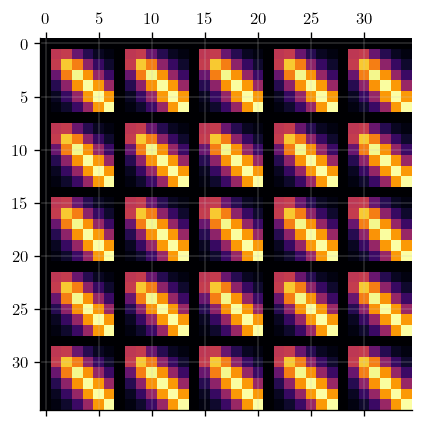

In [43]:
kxx_ker = p53_kxx(active_dims=[0])
t1 = dataset_train.X

plt.matshow(kxx_ker.gram(t1).to_dense())
plt.show()

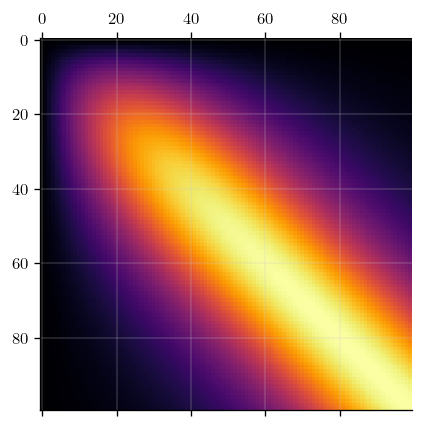

In [44]:
plt.matshow(kxx_ker.gram(testing_times).to_dense())
plt.show()

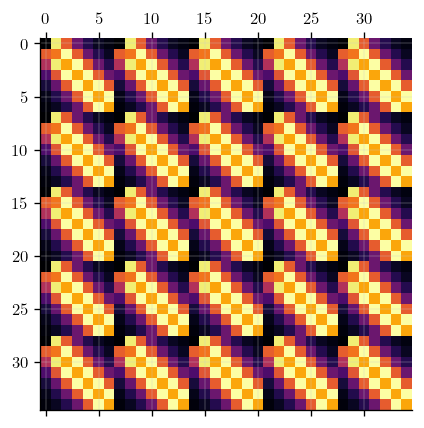

In [45]:
kxf_ker = p53_kxf(active_dims=[0])
plt.matshow(kxf_ker.gram(t1).to_dense())
plt.show()

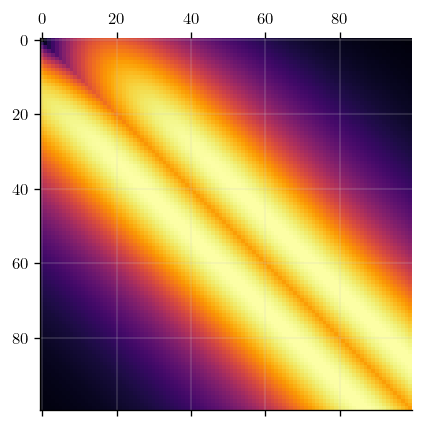

In [46]:
plt.matshow(kxf_ker.gram(testing_times).to_dense())
plt.show()

## Running GPR

Todo:

- Check Kxf (maths might be wrong)
- Look into shared params across sub kernels
- Look into how to obtain trained/learned parameters

In [47]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

meanf = gpx.mean_functions.Zero()
p53_ker = p53_combined_kernel()

posterior = initialise_gp(p53_ker, meanf, dataset_train)

In [48]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=dataset_train)

Array(424157.52445721, dtype=float64)

In [49]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior

In [50]:
opt_posterior = optimise_mll(posterior, dataset_train)

Optimization terminated successfully.
         Current function value: 1.506892
         Iterations: 79
         Function evaluations: 98
         Gradient evaluations: 98


In [21]:
params1 = jnp.array(jax.flatten_util.ravel_pytree(opt_posterior)[0])

In [22]:
params1

Array([ 0.58309917,  2.5       ,  2.5       , 19.75394539, 11.8853184 ,
        7.66053136,  0.40896155, 17.82449169,  9.29645473], dtype=float64)

In [51]:
from gpjax.base import meta_leaves

meta_leavs = meta_leaves(opt_posterior)
len(meta_leavs)

5

In [52]:
meta_leavs

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.15582735], dtype=float64)),
 ({'name': ' kff lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxf lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxxlengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=

In [53]:
opt_l = opt_posterior.prior.kernel.kernel_xx.l
print(opt_l)

3.5


In [26]:
opt_l / 3.0 - 0.5

Array(6.08464846, dtype=float64)

In [54]:
print(opt_posterior.prior.kernel.unconstrain().kernel_xx.l)

43.902821016488744


In [58]:
constrained_l = opt_posterior.prior.kernel.kernel_xx.l
print(constrained_l)

3.5


In [56]:
constrained_l = opt_posterior.prior.kernel.constrain().kernel_xx.l
print(constrained_l)

3.412063307745931


In [913]:
meta_leavs

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.77142391], dtype=float64)),
 ({'name': ' kff lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxf lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxxlengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_scale_of_shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_m

In [675]:
jax.flatten_util.ravel_pytree(opt_posterior)

(Array([0.24181486, 2.5       , 1.        , 2.5       , 0.29614982,
        2.5       ], dtype=float64),
 <jax._src.util.HashablePartial at 0x14a7d8650>)

In [672]:
def steal_diag_params(diag_params, dataset_coll_train, kernel):
    meanf = gpx.mean_functions.Zero()
    art_posterior = initialise_gp(kernel, meanf, dataset_coll_train)
    
    ravel_func = jax.flatten_util.ravel_pytree(art_posterior)[1]
    
    opt_art_posterior = ravel_func(diag_params)
    
    return opt_art_posterior

In [673]:
params1 = jnp.array([2,2,2,2,2])

In [674]:
stolen_params = steal_diag_params(params1, dataset_train, p53_ker)
jnp.array(jax.flatten_util.ravel_pytree(stolen_params)[0])

TypeError: cannot reshape array of shape (0,) (size 0) into shape () (size 1)

In [655]:
jnp.array(jax.flatten_util.ravel_pytree(stolen_params)[0])

Array([0.24181486, 2.5       , 1.        , 2.5       , 0.29614982],      dtype=float64)

In [611]:
latent_dist = opt_posterior.predict(testing_times, train_data=dataset_train)

In [612]:
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

In [613]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

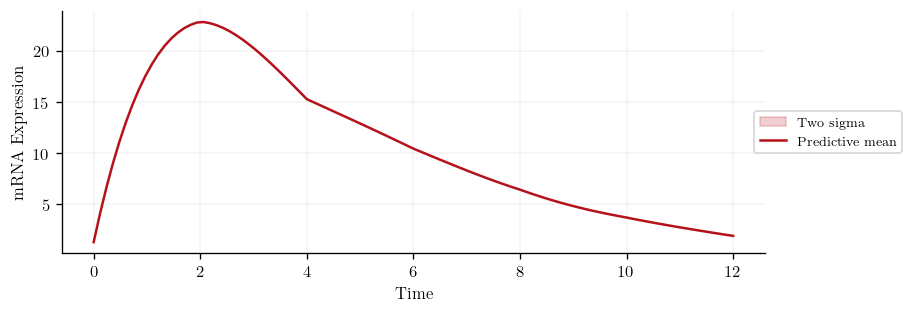

In [614]:
plot_gp(testing_times, predictive_dist)

In [615]:
# use new data loader
# plot to check ok
# load up kernels
# run gp regression
# look into shared params
# look into how to get learned params

In [616]:
print(jax.tree_util.tree_flatten(opt_posterior))

([Array([0.24181486], dtype=float64), Array(2.5, dtype=float64), Array(1., dtype=float64), Array(2.5, dtype=float64), Array(0.29614982, dtype=float64)], PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 35)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(p53_combined_kernel[(['kernel_ff', 'kernel_xf', 'kernel_xx'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'p53 Cov')])], [CustomNode(p53_kff[(['l', 'variance'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode(p53_kxf[(['l'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'cross covariance'), ('true_d', Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64)), ('true_s', Array([1., 1., 1., 1., 1.], dtype=float64))])], [*]), CustomNode

In [619]:
jax.flatten_util.ravel_pytree(opt_posterior)

(Array([0.24181486, 2.5       , 1.        , 2.5       , 0.29614982],      dtype=float64),
 <jax._src.util.HashablePartial at 0x14af89390>)

In [617]:
from gpjax.base import meta_leaves

meta_leaves(opt_posterior)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.24181486], dtype=float64)),
 ({'name': ' kff lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': 'rbf_variance',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': False,
   'pytree_node': True},
  Array(1., dtype=float64)),
 ({'name': ' kxf lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxxlengthscale',
   'bije

In [449]:
opt_posterior.prior.kernel

p53_combined_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 Cov', kernel_xx=p53_kxx(compute_engine=DenseKernelComputation(), active_dims=[0], name='kxx', true_s=Array([1., 1., 1., 1., 1.], dtype=float64), true_d=Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64), l=Array(0.29614982, dtype=float64)), kernel_xf=p53_kxf(compute_engine=DenseKernelComputation(), active_dims=[0], name='cross covariance', true_s=Array([1., 1., 1., 1., 1.], dtype=float64), true_d=Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64), l=Array(2.5, dtype=float64)), kernel_ff=p53_kff(compute_engine=DenseKernelComputation(), active_dims=[0], name='RBF', l=Array(1., dtype=float64), variance=Array(1., dtype=float64)))

In [422]:
len(meta_leaves(opt_posterior))

5

In [356]:
params, tree_structure = jax.tree_util.tree_flatten(opt_posterior)
print("Parameters:", params)
print("Tree Structure:", tree_structure)

Parameters: [Array([0.24181486], dtype=float64), Array(1., dtype=float64), Array(1., dtype=float64), Array(2.5, dtype=float64), Array(0.29614982, dtype=float64)]
Tree Structure: PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 35)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(p53_combined_kernel[(['kernel_ff', 'kernel_xf', 'kernel_xx'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'p53 Cov')])], [CustomNode(p53_kff[(['l', 'variance'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode(p53_kxf[(['l'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'cross covariance'), ('true_d', Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64)), ('true_s', Array([1., 1., 1., 1., 1.], dtype=float

In [291]:
pass